In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions


In [2]:

def perturb_normal_mixture(orig_means, orig_variances, orig_weights, 
                           comp_out=10000, alpha=500):
    """
    Returns a perturbation of a mixture:
    
    Given a mixture
            f(y) = \sum_j w_j N(y | \mu_j, \Sigma_j)
    returns
            f'(y) = \sum_k w'_k N(y | \mu'_j, 0.2^2 * I)
    where
    1. mu'_k are the new location centers, obtained by sampling
            c_k ~ Categorical(w_1, .. w_J)
            mu'_k | c_k ~ N(mu_{c_k}, \Sigma_{c_k})
              for k=1, ... comp_out
    2. w'_k are normalized weights (sum to 1) and their length
       is `comp_out` 
           w_k ~ Dirichlet(alpha/comp_out)
    
    """
    univariate = len(orig_means.shape) == 1
    
    c_ks = np.random.choice(
        len(orig_weights), size=comp_out, replace=True, p=orig_weights)
    
    if univariate:
        locations = tfd.Normal(orig_means[c_ks], np.sqrt(orig_variances)[c_ks]).sample()
        variances = np.ones(comp_out) * 0.2 ** 2
    else:
        locations = tfd.MultivariateNormalFullCovariance(
            orig_means[c_ks], np.sqrt(orig_variances)[c_ks]).sample()
        variances = np.stack([np.eye(orig_means.shape[1]) * 0.2 ** 2] * comp_out)
    weights = tfd.Dirichlet(np.ones(comp_out) * alpha / comp_out).sample()
    return locations, variances, weights

def eval_univariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.Normal(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)

def eval_multivariate_mixture_dens(locations, variances, weights, xgrid):
    eval_comps = tfd.MultivariateNormalFullCovariance(locations, np.sqrt(variances)).prob(xgrid[:, np.newaxis])
    return np.sum(eval_comps * weights, axis=1)


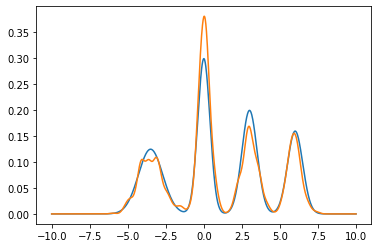

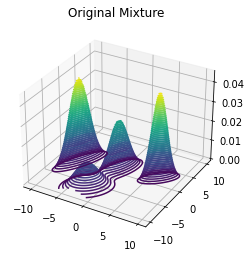

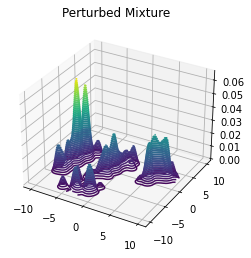

In [3]:
#Univariate Data
true_mu = np.array([-3.5, 3, 0, 6])
true_sigma = np.array([0.8, 0.5, 0.4, 0.5]) ** 2
w_t = np.array([0.25, 0.25, 0.3, 0.2])
xgrid = np.linspace(-10, 10, 1000)

pert_mu, pert_sigma, pert_w = perturb_normal_mixture(true_mu, true_sigma, w_t)
plt.plot(xgrid, eval_univariate_mixture_dens(true_mu, true_sigma, w_t, xgrid))
plt.plot(xgrid, eval_univariate_mixture_dens(pert_mu, pert_sigma, pert_w , xgrid))




#Multivariate Data
true_mu_bi = np.array([  [-7,-2] , [0,0] , [-1,-7] , [1,7]  ])
true_sigma_bi = np.array([  [[10,1] , [1, 10]] ,   [[10 , 1] , [1 , 1]] ,[[10,1] , [2, 1]],[[1,0.5] , [0.5, 1]]   ])
grid_1D = np.linspace(-10, 10, 100)
grid_2D = np.array([[x0, y0] for x0 in grid_1D for y0 in grid_1D])
X,Y = np.meshgrid(grid_1D,grid_1D) 

#Few components otherwise computations are very long
#Also the grid of points is less refined
pert_mu_bi, pert_sigma_bi, pert_w_bi = perturb_normal_mixture(true_mu_bi, true_sigma_bi, w_t,comp_out = 100)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y,np.reshape(eval_multivariate_mixture_dens(true_mu_bi, true_sigma_bi, w_t, grid_2D), newshape = X.shape) , 50, cmap='viridis')
ax.set_title('Original Mixture');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y,np.reshape(eval_multivariate_mixture_dens(pert_mu_bi, pert_sigma_bi, pert_w_bi, grid_2D), newshape = X.shape) , 50, cmap='viridis')
ax.set_title('Perturbed Mixture');

#Attention
#I generate the grid_2D with a for loop, and it is vector of coordinates,so grid_2D=[[x_1,y_1], ... [x_n,y_n]]
#To plot in 3D however i need to construct a grid using np.meshgrid and evaluate the densities over this grid,
#which is constructed differently from grid_2D.
#However, .prob(..) only works on grid_2D, so i reshape the output of eval_multivariate_mixture_dens 
# to have the same shape of the np.meshgrid, and it seems to reorder the points correctly, but it is lucky or wrong

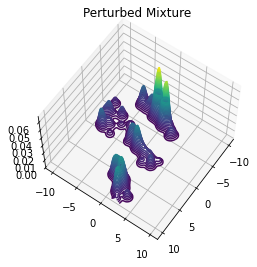

In [4]:
ax.view_init(60, 35)
fig

In [6]:
true = np.reshape(eval_multivariate_mixture_dens(true_mu_bi, true_sigma_bi, w_t, grid_2D), newshape = X.shape)

In [7]:
perturbed = np.reshape(eval_multivariate_mixture_dens(pert_mu_bi, pert_sigma_bi, pert_w_bi, grid_2D), newshape = X.shape)

In [8]:
np.save('true.npy', true)
np.save('perturbed.npy', perturbed)